In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
weather_event_cat = {
    'inconnu': 1, 'pluie faible': 2, 'ciel clair': 3, 'brouillard faible': 4, 'pluie': 5, 'brouillard': 6,
    'neige faible': 7, 'pluie forte': 8, 'neige': 9, 'brouillard fort': 10
}

atmo_cat = {'bon': 1, 'moyen': 2, 'dégradé': 3, 'mauvais': 4, "très mauvais": 5, "extrêmement mauvais": 6}

wind_dir_cat = {
    'SO': 1, 'O': 2, 'SSO': 3, 'N': 4, 'S': 5, 'NE': 6, 'OSO': 7, 'NNO': 8, 'ONO': 9, 'ENE': 10, 'E': 11,
    'NNE': 12, 'NO': 13, 'SSE': 14, 'SE': 15, 'ESE': 16
}

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/thibaultrichel/citeos-air-quality/main/data/final/merged-final.csv", sep=';').dropna().drop("day", axis=1)
df["wind_dir_cat"] = df.wind_dir.apply(lambda x: wind_dir_cat[x])
df["weather_event_cat"] = df.weather_event.apply(lambda x: weather_event_cat[x])
df["atmo_cat"] = df.ATMO.apply(lambda x: atmo_cat[x])
df = df.drop(["ATMO", "weather_event", "wind_dir"], axis=1)
df

,date,PM10,PM25,NO2,SO2,NO,NOX,O3,temp,wind_speed,hum,press,wind_dir_cat,weather_event_cat,atmo_cat
0,2019-01-01 01:00:00,5.9,9.2,18.6,2.4,1.3,20.7,41.8,8.2,3.7,84.0,1036.0,9,1,1
1,2019-01-01 02:00:00,5.4,10.3,19.7,2.3,1.4,21.9,39.8,7.9,3.7,90.0,1036.2,8,1,2
2,2019-01-01 03:00:00,8.6,12.9,24.3,2.1,0.7,25.4,32.8,7.7,3.7,88.0,1035.8,2,1,2
3,2019-01-01 04:00:00,10.2,12.5,25.4,2.6,1.0,27.0,36.6,7.9,3.7,82.0,1035.4,9,1,2
4,2019-01-01 05:00:00,11.1,6.9,18.2,3.1,0.6,19.2,48.9,8.0,3.7,81.0,1034.8,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26271,2021-12-30 17:00:00,11.4,8.1,23.9,0.9,1.5,26.2,25.2,13.9,14.8,87.0,1022.3,1,3,1
26272,2021-12-30 18:00:00,10.8,7.5,27.7,0.6,2.3,31.2,20.9,14.0,14.8,87.0,1022.7,3,3,1
26273,2021-12-30 19:00:00,11.9,8.4,25.8,0.6,1.1,27.6,21.2,13.4,13.0,88.0,1022.8,3,3,1
26274,2021-12-30 20:00:00,11.8,8.8,31.1,0.6,1.1,32.9,14.2,12.5,11.1,91.0,1022.9,3,3,1


In [8]:
train_size = int(df.shape[0]*0.75)
test_size = df.shape[0] - train_size
df_train = df[:train_size].drop("date", axis=1)
df_test = df[train_size:].drop("date", axis=1)

In [9]:
train = df_train
scalers={}
for i in df_train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = df_test
for i in df_train.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [10]:
def split_series(series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations 
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [11]:
n_past = 120
n_future = 12
n_features = 14

In [12]:
X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [13]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 14)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        46000       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 12, 100)      0           ['lstm[0][0]']                   
                                                                                              

In [14]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.compile(optimizer="adam", loss="huber")

In [16]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test,y_test),
    batch_size=32,
    verbose=1,
    shuffle=False,
    callbacks=[reduce_lr]
)

Epoch 1/50
597/597 [==============================] - 25s 41ms/step - loss: 0.0338 - val_loss: 0.0354 - lr: 0.0010
Epoch 2/50
597/597 [==============================] - 23s 39ms/step - loss: 0.0310 - val_loss: 0.0341 - lr: 9.0000e-04
Epoch 3/50
597/597 [==============================] - 24s 40ms/step - loss: 0.0289 - val_loss: 0.0316 - lr: 8.1000e-04
Epoch 4/50
597/597 [==============================] - 24s 39ms/step - loss: 0.0269 - val_loss: 0.0297 - lr: 7.2900e-04
Epoch 5/50
597/597 [==============================] - 23s 39ms/step - loss: 0.0260 - val_loss: 0.0285 - lr: 6.5610e-04
Epoch 6/50
597/597 [==============================] - 24s 40ms/step - loss: 0.0253 - val_loss: 0.0275 - lr: 5.9049e-04
Epoch 7/50
597/597 [==============================] - 24s 40ms/step - loss: 0.0249 - val_loss: 0.0269 - lr: 5.3144e-04
Epoch 8/50
597/597 [==============================] - 23s 39ms/step - loss: 0.0246 - val_loss: 0.0264 - lr: 4.7830e-04
Epoch 9/50
597/597 [==============================] 

In [17]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

<Figure size 720x576 with 0 Axes>

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

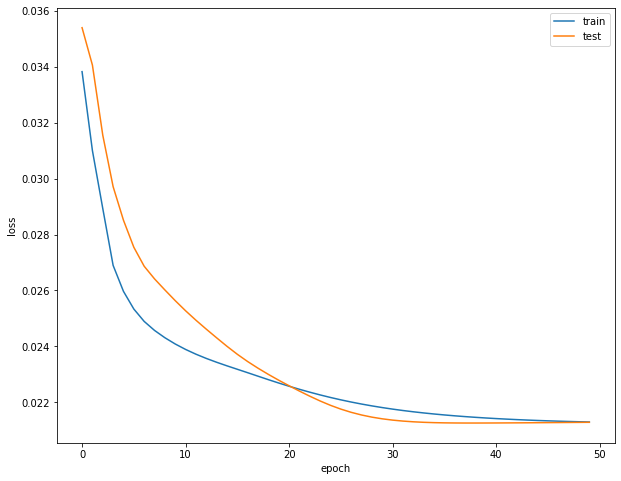

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [19]:
y_pred = model.predict(X_test)

In [20]:
for index,i in enumerate(df_train.columns):
    scaler = scalers['scaler_'+i]
    y_pred[:,:,index]=scaler.inverse_transform(y_pred[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [22]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
for index,i in enumerate(df_train.columns):
    print(i)
    for j in range(1, n_future+1):
        print("Hour ", j, ":")
        print("MAPE : ", mean_absolute_percentage_error(y_test[:, j-1, index], y_pred[:, j-1, index]))
    print()

PM10
Hour  1 :
MAPE :  0.2844773399748075
Hour  2 :
MAPE :  0.3278434129726599
Hour  3 :
MAPE :  0.3685386137200119
Hour  4 :
MAPE :  0.3985600063481972
Hour  5 :
MAPE :  0.42584225709714685
Hour  6 :
MAPE :  0.4473583245683181
Hour  7 :
MAPE :  0.4638066355361424
Hour  8 :
MAPE :  0.4757725001713472
Hour  9 :
MAPE :  0.4846629216736175
Hour  10 :
MAPE :  0.4912208428854229
Hour  11 :
MAPE :  0.4966837176563053
Hour  12 :
MAPE :  0.5015386831189014

PM25
Hour  1 :
MAPE :  72887163597218.4
Hour  2 :
MAPE :  78497276654320.8
Hour  3 :
MAPE :  90475031477269.42
Hour  4 :
MAPE :  98436688262207.27
Hour  5 :
MAPE :  106525682575820.38
Hour  6 :
MAPE :  113776721887901.38
Hour  7 :
MAPE :  112964487899262.02
Hour  8 :
MAPE :  113269848295717.22
Hour  9 :
MAPE :  109255794766911.38
Hour  10 :
MAPE :  109890131545694.69
Hour  11 :
MAPE :  111025156602232.81
Hour  12 :
MAPE :  105364352042966.86

NO2
Hour  1 :
MAPE :  0.34471669334862054
Hour  2 :
MAPE :  0.4151693467060463
Hour  3 :
MAPE :  0.